<a href="https://colab.research.google.com/github/anirban2k22/Stock-Market-Sentiment-Analysis-Using-LLMs/blob/main/Stock_Market_Sentiment_Analysis_Using_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q -U google-generativeai pandas requests beautifulsoup4 matplotlib plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 49.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
pip install pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3


In [ ]:
import google.generativeai as genai
import os

# --- Replace with your actual Gemini API Key ---
# Keep your key secret! Do not share it publicly.
GOOGLE_API_KEY = "YOUR_GOOGLE_API_KEY_GOES_HERE" # <-- PUT YOUR REAL GEMINI KEY HERE
# -----------------------------------------------

try:
    genai.configure(api_key=GOOGLE_API_KEY)
    # Choose a Gemini model - 'gemini-1.5-flash' is fast and good for this
    model = genai.GenerativeModel('gemini-1.5-flash')
    print("Gemini API configured successfully!")
except Exception as e:
    print(f"Error configuring Gemini API: {e}")
    print("Please ensure you have replaced 'YOUR_GOOGLE_API_KEY' with a valid key.")

Gemini API configured successfully!


In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import re # Import regular expressions for more flexible matching

def fetch_yahoo_finance_news(): # Keeping the same function name
    """
    Fetches news headlines and links from the Yahoo Finance news page.
    (Updated logic v3: Targets <a> tags directly and filters)
    """
    url = "https://finance.yahoo.com/news/"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"} # More specific user agent
    news_headlines = []
    processed_links = set() # To avoid duplicates

    print(f"Attempting to fetch news from: {url}")

    try:
        response = requests.get(url, headers=headers, timeout=15) # Increased timeout
        response.raise_for_status()

        print("Successfully fetched page content. Parsing HTML (v3 logic)...")
        soup = BeautifulSoup(response.text, "html.parser")

        headlines_found = 0
        # --- Updated Logic v3 ---
        # Find all link tags <a> with an href attribute
        link_tags = soup.find_all("a", href=True)

        print(f"Found {len(link_tags)} total links. Filtering for news...")

        for link_tag in link_tags:
            link_url = link_tag['href']
            headline_text = link_tag.get_text(strip=True)

            # Basic Filtering Criteria:
            # 1. Link must contain '/news/' or '/video/' (sometimes news includes videos)
            # 2. Link should ideally start with '/' (relative) or the base finance URL
            # 3. Must have non-empty headline text
            # 4. Avoid common non-news text/patterns
            # 5. Avoid duplicates

            is_news_link = ('/news/' in link_url or '/video/' in link_url)
            is_relevant_domain = link_url.startswith('/') or link_url.startswith('https://finance.yahoo.com')
            has_text = bool(headline_text)
            not_common_junk = headline_text not in ["Yahoo Finance", "News", "Finance", "Watchlist", "My Portfolio", "Screeners", "Markets", "Industries", "Trending Tickers", "More", "Less"] and len(headline_text) > 10 # Require reasonable length

            if is_news_link and is_relevant_domain and has_text and not_common_junk:
                # Complete the URL if it's relative
                if link_url.startswith('/'):
                    full_url = "https://finance.yahoo.com" + link_url
                else:
                    full_url = link_url

                # Avoid duplicates based on URL
                if full_url not in processed_links:
                     news_headlines.append({
                         "headline": headline_text,
                         "link": full_url
                     })
                     processed_links.add(full_url)
                     headlines_found += 1

        # --- End Updated Logic v3 ---

        print(f"Found {headlines_found} potential headlines using updated logic v3.")
        if not news_headlines:
             print("Warning: No headlines found with updated logic v3. Website structure may need further, manual inspection using browser developer tools.")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching news: {e}")
    except Exception as e:
        print(f"An error occurred during scraping: {e}")

    return news_headlines

In [ ]:
# Call the function (which now uses the v3 logic)
news_data = fetch_yahoo_finance_news()

# Check if we got any data back and print the first few items
if news_data:
    print(f"\nSuccessfully retrieved {len(news_data)} headlines.")
    print("First 5 headlines (using updated logic v3):")
    # Print the first 5 items prettily
    for i, news_item in enumerate(news_data[:5]):
        print(f"  {i+1}. Headline: {news_item['headline']}")
        print(f"     Link: {news_item['link']}")
else:
    print("\nFailed to retrieve news headlines with updated logic v3.")
    if isinstance(news_data, list) and not news_data:
        print("The scraping function ran but returned an empty list.")
        print("This could indicate the website requires JavaScript to load news, uses very dynamic classes, or needs even more specific targeting.")
        print("If this fails, the next step might be exploring official News APIs or trying libraries like Selenium (which mimics a full browser).")

Attempting to fetch news from: https://finance.yahoo.com/news/
Successfully fetched page content. Parsing HTML (v3 logic)...
Found 492 total links. Filtering for news...
Found 11 potential headlines using updated logic v3.

Successfully retrieved 11 headlines.
First 5 headlines (using updated logic v3):
  1. Headline: Tariff Updates
     Link: https://finance.yahoo.com/news/live/live-president-trump-reiterates-threat-of-25-tariffs-on-canada-mexico-as-deadline-looms-191201171.html
  2. Headline: What To Do With Your Money If Trump Changes the FDICThe Federal Deposit Insurance Corporation (FDIC), which protects insured bank deposits, may be facing changes. According to CNN, in late 2024, then-President-elect Donald Trump's allies were talking...
     Link: https://finance.yahoo.com/news/money-trump-changes-fdic-130247177.html
  3. Headline: My dad’s wealth manager put my entire $50K in savings into one investment. Is he setting me up for disaster?Putting all of your eggs in one basket is

In [ ]:
import time # Already imported, but good practice if run standalone

# We already configured genai and the model in Step 3

def analyze_sentiment(text):
    """
    Analyzes the sentiment of a given text using the configured Gemini model.
    Returns 'Positive', 'Negative', or 'Neutral'.
    """
    # Simple prompt asking for one-word classification
    prompt = f"""Analyze the sentiment of the following financial news headline and classify it *only* as Positive, Negative, or Neutral. Do not add any explanation or extra text, just the single word classification.

    Headline: '{text}'

    Sentiment:"""

    try:
        # Make the API call to Gemini (using the 'model' variable from Step 3)
        response = model.generate_content(prompt)

        # Basic cleaning and checking of the response
        sentiment = response.text.strip().capitalize()

        # Ensure the output is one of the expected categories
        if sentiment not in ["Positive", "Negative", "Neutral"]:
            # If Gemini gave an unexpected response, try to infer or default
            print(f"Warning: Unexpected response '{response.text}'. Defaulting.")
            if "positive" in response.text.lower():
                sentiment = "Positive"
            elif "negative" in response.text.lower():
                sentiment = "Negative"
            else:
                sentiment = "Neutral" # Default fallback

        # Optional: Add a small delay to respect API rate limits if needed
        # time.sleep(1) # Pause for 1 second between API calls

        return sentiment

    # Handle potential errors during the API call
    except Exception as e:
        print(f"An error occurred during Gemini API call for text: '{text[:50]}...'")
        print(f"Error: {e}")
        # Check if it's an authentication error (though unlikely if Step 3 worked)
        if "API key not valid" in str(e):
             print("Authentication Error: Please re-check your Gemini API key configuration (Step 3).")
        return "Error" # Return an error indicator

In [ ]:
# Define sample headlines
positive_headline = "Innovate Corp announces breakthrough technology, stock price jumps 20%!"
negative_headline = "Global Foods Inc. issues profit warning citing rising costs, shares drop sharply."

# Analyze the positive headline
print(f"Analyzing: '{positive_headline}'")
sentiment_positive = analyze_sentiment(positive_headline)
print(f"Result: {sentiment_positive}")

print("-" * 20) # Separator

# Analyze the negative headline
print(f"Analyzing: '{negative_headline}'")
sentiment_negative = analyze_sentiment(negative_headline)
print(f"Result: {sentiment_negative}")

Analyzing: 'Innovate Corp announces breakthrough technology, stock price jumps 20%!'
Result: Positive
--------------------
Analyzing: 'Global Foods Inc. issues profit warning citing rising costs, shares drop sharply.'
Result: Negative


In [ ]:
import pandas as pd # Make sure pandas is imported

def classify_news(news_list):
    """
    Analyzes sentiment for a list of news items and returns a Pandas DataFrame.

    Args:
        news_list: A list of dictionaries, where each dict has 'headline' and 'link'.

    Returns:
        A pandas DataFrame with 'Headline', 'Sentiment', 'Link' columns.
    """
    data_for_df = [] # List to hold data for the DataFrame
    total_items = len(news_list)
    print(f"Starting sentiment classification for {total_items} news items...")

    # Loop through each news item in the provided list
    for i, news_item in enumerate(news_list):
        headline = news_item.get('headline', '') # Use .get for safety
        link = news_item.get('link', '')

        if not headline:
            print(f"Skipping item {i+1}/{total_items} due to missing headline.")
            continue # Skip if headline is missing

        print(f"  Classifying headline {i+1}/{total_items}: '{headline[:70]}...'") # Print progress

        # Call our sentiment analysis function
        sentiment = analyze_sentiment(headline) # This calls the Gemini API

        # Append the results to our list
        data_for_df.append({
            "Headline": headline,
            "Sentiment": sentiment, # Will be 'Positive', 'Negative', 'Neutral', or 'Error'
            "Link": link
        })

    print(f"\nFinished classification.")

    # Convert the list of dictionaries into a Pandas DataFrame
    df = pd.DataFrame(data_for_df)
    return df

In [ ]:
# Make sure news_data exists from Step 5 (v3) test run
if 'news_data' in locals() and news_data:
    print(f"Processing {len(news_data)} headlines found earlier...")

    # Call the function to classify the news and get the DataFrame
    df_news_sentiment = classify_news(news_data)

    # Display the resulting DataFrame
    print("\n--- Resulting DataFrame ---")
    # Display settings to show more text in columns if needed
    pd.set_option('display.max_colwidth', 100) # Show more headline text
    print(df_news_sentiment)

elif 'news_data' in locals() and not news_data:
    print("The 'news_data' variable is empty. Please re-run the scraping test (Step 5 v3) successfully first.")
else:
    print("The 'news_data' variable does not exist. Please run the scraping steps first (Step 4 v3 and Step 5 v3).")

Processing 11 headlines found earlier...
Starting sentiment classification for 11 news items...
  Classifying headline 1/11: 'Tariff Updates...'
  Classifying headline 2/11: 'What To Do With Your Money If Trump Changes the FDICThe Federal Deposi...'
  Classifying headline 3/11: 'My dad’s wealth manager put my entire $50K in savings into one investm...'
  Classifying headline 4/11: 'HSBC Cuts Tesla (TSLA) Price Target, Citing Aging Products and China P...'
  Classifying headline 5/11: 'After the Recent Stock Market Drama, Where Will Artificial Intelligenc...'
  Classifying headline 6/11: 'AppLovin (APP) Set to Dominate Mobile Marketing with AI-Powered Audien...'
  Classifying headline 7/11: 'JPMorgan Stays Optimistic on Constellation Energy (CEG) Despite Bearis...'
  Classifying headline 8/11: 'Alphabet Inc. (GOOGL)’s AI Powers Lockheed Martin’s National Security ...'
  Classifying headline 9/11: 'Spectral AI Inc. (MDAI) Poised for FDA Approval with Revolutionary Dee...'
  Classifying h

In [ ]:
import matplotlib.pyplot as plt # Make sure plotting library is imported

def plot_sentiment_distribution(df):
    """
    Generates and displays a bar chart of sentiment counts from a DataFrame.

    Args:
        df: A pandas DataFrame with a 'Sentiment' column.
    """
    # Ensure the DataFrame is not empty and has the 'Sentiment' column
    if df is None or df.empty or 'Sentiment' not in df.columns:
        print("DataFrame is empty or missing 'Sentiment' column. Cannot plot.")
        return

    print("Generating sentiment distribution plot...")

    # Get the counts for each sentiment category
    sentiment_counts = df['Sentiment'].value_counts()

    # Define colors for the bars (optional, but nice)
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'grey', 'Error': 'orange'}
    bar_colors = [colors.get(sentiment, 'blue') for sentiment in sentiment_counts.index] # Get color for each bar

    # Create the bar plot
    plt.figure(figsize=(8, 5)) # Set the figure size
    sentiment_counts.plot(kind='bar', color=bar_colors)

    # Add titles and labels
    plt.title('Distribution of News Sentiment')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Number of Headlines')
    plt.xticks(rotation=0) # Keep x-axis labels horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines

    # Display the plot
    plt.show()

Generating sentiment distribution plot...


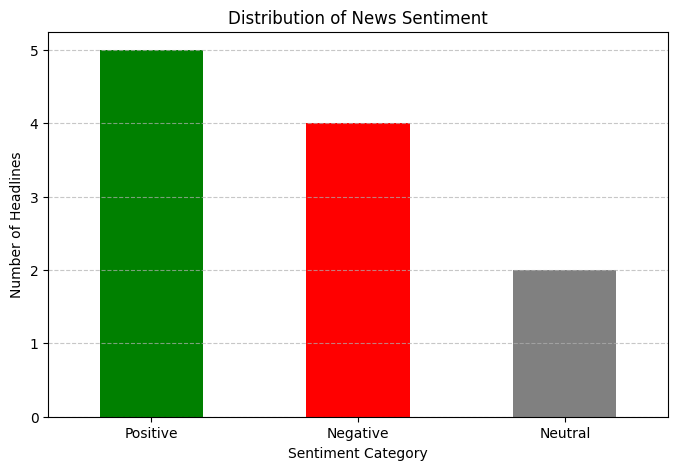

In [ ]:
# Make sure the DataFrame exists from Step 9
if 'df_news_sentiment' in locals() and not df_news_sentiment.empty:
    # Call the function to plot the distribution
    plot_sentiment_distribution(df_news_sentiment)
else:
    print("The 'df_news_sentiment' DataFrame does not exist or is empty.")
    print("Please ensure Step 9 ran successfully and created the DataFrame.")

In [ ]:
# Check if the DataFrame exists before saving
if 'df_news_sentiment' in locals() and not df_news_sentiment.empty:
    try:
        # Save the DataFrame to a CSV file in the Colab environment
        csv_filename = 'yahoo_news_sentiment.csv'
        df_news_sentiment.to_csv(csv_filename, index=False) # index=False prevents writing row numbers to the file
        print(f"DataFrame successfully saved to '{csv_filename}'")

        # You can find the file in the Colab file browser (folder icon on the left panel)
        # You can download it from there if you wish.

    except Exception as e:
        print(f"Error saving DataFrame to CSV: {e}")
else:
    print("Could not save: 'df_news_sentiment' DataFrame not found or is empty.")

DataFrame successfully saved to 'yahoo_news_sentiment.csv'


In [ ]:
pd.read_csv('yahoo_news_sentiment.csv')

,Headline,Sentiment,Link
0,Tariff Updates,Neutral,https://finance.yahoo.com/news/live/live-president-trump-reiterates-threat-of-25-tariffs-on-cana...
1,What To Do With Your Money If Trump Changes the FDICThe Federal Deposit Insurance Corporation (F...,Negative,https://finance.yahoo.com/news/money-trump-changes-fdic-130247177.html
2,My dad’s wealth manager put my entire $50K in savings into one investment. Is he setting me up f...,Negative,https://finance.yahoo.com/news/dad-wealth-manager-put-entire-104400778.html
3,"HSBC Cuts Tesla (TSLA) Price Target, Citing Aging Products and China PressureWe recently publish...",Negative,https://finance.yahoo.com/news/hsbc-cuts-tesla-tsla-price-162417289.html
4,"After the Recent Stock Market Drama, Where Will Artificial Intelligence (AI) Leader Palantir Be ...",Negative,https://finance.yahoo.com/news/recent-stock-market-drama-where-190000412.html
5,AppLovin (APP) Set to Dominate Mobile Marketing with AI-Powered Audience+ PlatformWe recently pu...,Positive,https://finance.yahoo.com/news/applovin-app-set-dominate-mobile-162357969.html
6,JPMorgan Stays Optimistic on Constellation Energy (CEG) Despite Bearish SentimentWe recently pub...,Positive,https://finance.yahoo.com/news/jpmorgan-stays-optimistic-constellation-energy-162334066.html
7,Alphabet Inc. (GOOGL)’s AI Powers Lockheed Martin’s National Security InnovationsWe recently pub...,Positive,https://finance.yahoo.com/news/alphabet-inc-googl-ai-powers-162315937.html
8,Spectral AI Inc. (MDAI) Poised for FDA Approval with Revolutionary DeepView SystemWe recently pu...,Positive,https://finance.yahoo.com/news/spectral-ai-inc-mdai-poised-162258136.html
9,CrowdStrike (CRWD) Gains Bullish Support from J.P. Morgan Amid ARR AccelerationWe recently publi...,Positive,https://finance.yahoo.com/news/crowdstrike-crwd-gains-bullish-support-162222991.html
